In [1]:
import os
import torch
import numpy as np
import pandapower as pp
import pandapower.networks as pn
from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt

# 路径配置
RAW_PATH = "../data/processed/cigre_lv_stress_test_v1.pt"
SAVE_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"

# 1. 加载原始数据 (关键修正: weights_only=False 以支持 numpy/sklearn 对象)
if not os.path.exists(RAW_PATH):
    raise FileNotFoundError(f"❌ Raw data not found at {RAW_PATH}. Run Notebook 01 first!")

try:
    # PyTorch 2.6+ 需要显式允许加载非 Tensor 对象
    raw_data = torch.load(RAW_PATH, weights_only=False)
except TypeError:
    # 旧版本 PyTorch 不需要这个参数
    raw_data = torch.load(RAW_PATH)

X_raw = raw_data['X'].numpy()      # [N, 3] (P_tot, Q_tot, Time)
Y_v_raw = raw_data['Y_v'].numpy()  # [N, Nodes] (Voltage)
Y_p_raw = raw_data['Y_p'].numpy()  # [N, Loads] (Active Power Injection)

print(f"✅ Loaded raw data. Samples: {X_raw.shape[0]}")
print(f"   Raw P shape: {Y_p_raw.shape} (Sparse, only loads)")

✅ Loaded raw data. Samples: 50016
   Raw P shape: (50016, 15) (Sparse, only loads)


In [2]:
def extract_graph_and_mapping(raw_y_p_dim):
    # 1. 创建网络以获取标准拓扑
    net = pn.create_cigre_network_lv()
    
    # --- A. 建立节点映射 (Bus ID -> 0..43 Index) ---
    bus_ids = net.bus.index.values
    # lookup table: 真实 Bus ID -> 连续的 0~N-1 索引
    bus_mapper = {b_id: i for i, b_id in enumerate(bus_ids)}
    n_nodes = len(bus_ids)
    
    # --- B. 建立负荷映射 (Load Index -> Bus Index) ---
    # 我们需要知道 net.load 的第 i 行连在哪个 Bus 上
    load_bus_ids = net.load.bus.values 
    load_to_bus_idx = [bus_mapper[b_id] for b_id in load_bus_ids]
    
    # 维度检查
    if len(load_to_bus_idx) != raw_y_p_dim:
        raise ValueError(f"Mismatch! Data has {raw_y_p_dim} loads, but topology has {len(load_to_bus_idx)}.")

    # --- C. 提取边 (Lines + Trafos + SWITCHES) ---
    src, dst, r_list, x_list = [], [], [], []

    # (1) Lines (线路)
    for _, row in net.line.iterrows():
        src.append(bus_mapper[row.from_bus])
        dst.append(bus_mapper[row.to_bus])
        r_list.append(row.length_km * row.r_ohm_per_km)
        x_list.append(row.length_km * row.x_ohm_per_km)
        
    # (2) Trafos (变压器)
    for _, row in net.trafo.iterrows():
        src.append(bus_mapper[row.hv_bus])
        dst.append(bus_mapper[row.lv_bus])
        r_list.append(0.001) # 简化阻抗
        x_list.append(0.01)

    # (3) Switches (开关) - 关键修复点！
    # CIGRE LV 中，闭合的开关构成了母线连接，必须视为物理连接
    for _, row in net.switch.iterrows():
        if row.closed: 
            # 确保连接的两端都在我们的 bus 列表里
            if row.bus in bus_mapper and row.element in bus_mapper:
                src.append(bus_mapper[row.bus])
                dst.append(bus_mapper[row.element])
                r_list.append(1e-4) # 极小阻抗
                x_list.append(1e-4)

    # 构建双向图 (Undirected Graph)
    final_src = src + dst
    final_dst = dst + src
    final_r = r_list + r_list
    final_x = x_list + x_list
    
    edge_index = torch.tensor([final_src, final_dst], dtype=torch.long)
    edge_attr = torch.tensor(np.stack([final_r, final_x], axis=1), dtype=torch.float)
    
    return edge_index, edge_attr, load_to_bus_idx, n_nodes

# 执行提取
edge_index, edge_attr, load_map, n_nodes = extract_graph_and_mapping(Y_p_raw.shape[1])

print(f"🔗 Corrected Topology:")
print(f"   Nodes: {n_nodes} (Expected 44)")
print(f"   Edges: {edge_index.shape[1]} (Physical connections * 2)")
print(f"   Load Map indices: {load_map}")

🔗 Corrected Topology:
   Nodes: 44 (Expected 44)
   Edges: 86 (Physical connections * 2)
   Load Map indices: [2, 12, 16, 17, 18, 19, 22, 24, 35, 36, 37, 40, 41, 42, 43]


In [3]:
def process_and_scale(X, Y_v, Y_p_sparse, load_map, n_nodes):
    """
    Y_p_sparse: [N, 15] -> 只有负荷点的功率
    load_map: [15] -> 负荷点对应的节点索引
    target: [N, 44] -> 全网节点功率 (非负荷点填 0)
    """
    n_samples = X.shape[0]
    
    # 1. 扩展功率矩阵 (Map 15 cols to 44 cols)
    print("Expanding Power Injections to Full Bus Matrix...")
    Y_p_full = np.zeros((n_samples, n_nodes), dtype=np.float32)
    
    # 将稀疏的负荷数据填入对应的节点列
    for i, bus_idx in enumerate(load_map):
        Y_p_full[:, bus_idx] = Y_p_sparse[:, i]
        
    print(f"   Expansion done. Y_p shape: {Y_p_full.shape}")

    # 2. 划分数据集 (Train/Val/Test)
    indices = np.arange(n_samples)
    # 保持时序还是打乱？通常状态估计可以打乱。
    # np.random.shuffle(indices) 
    
    split_1 = int(0.8 * n_samples)
    split_2 = int(0.9 * n_samples)
    
    train_idx = indices[:split_1]
    val_idx = indices[split_1:split_2]
    test_idx = indices[split_2:]
    
    # 3. 标准化 (Scaling)
    # 只在 Train 上 fit，防止数据泄露
    scaler_x = StandardScaler().fit(X[train_idx, :2])     # Global Features
    scaler_y_v = StandardScaler().fit(Y_v[train_idx])     # Voltages (Target)
    scaler_y_p = StandardScaler().fit(Y_p_full[train_idx]) # Node Injections
    
    # Transform
    X_norm = X.copy()
    X_norm[:, :2] = scaler_x.transform(X[:, :2])
    
    Y_v_norm = scaler_y_v.transform(Y_v)
    Y_p_norm = scaler_y_p.transform(Y_p_full)
    
    # 转 PyTorch Tensor
    return (torch.from_numpy(X_norm).float(),
            torch.from_numpy(Y_v_norm).float(),
            torch.from_numpy(Y_p_norm).float(),
            torch.from_numpy(train_idx), 
            torch.from_numpy(val_idx), 
            torch.from_numpy(test_idx),
            {'x': scaler_x, 'y_v': scaler_y_v, 'y_p': scaler_y_p})

# 执行处理
X_norm, Y_v_norm, Y_p_norm, train_idx, val_idx, test_idx, scalers = \
    process_and_scale(X_raw, Y_v_raw, Y_p_raw, load_map, n_nodes)

print(f"📊 Final Data Shapes:")
print(f"   Y_v (Voltage): {Y_v_norm.shape} (Should be N, 44)")
print(f"   Y_p (Power):   {Y_p_norm.shape} (Should be N, 44)")

Expanding Power Injections to Full Bus Matrix...
   Expansion done. Y_p shape: (50016, 44)
📊 Final Data Shapes:
   Y_v (Voltage): torch.Size([50016, 44]) (Should be N, 44)
   Y_p (Power):   torch.Size([50016, 44]) (Should be N, 44)


✅ Saved processed dataset to ../data/processed/cigre_lv_graph_dataset_v1.pt

🔍 Verifying Graph Connectivity...
   Is Connected? True
🎉 SUCCESS: Graph is fully connected! Ready for GNN.


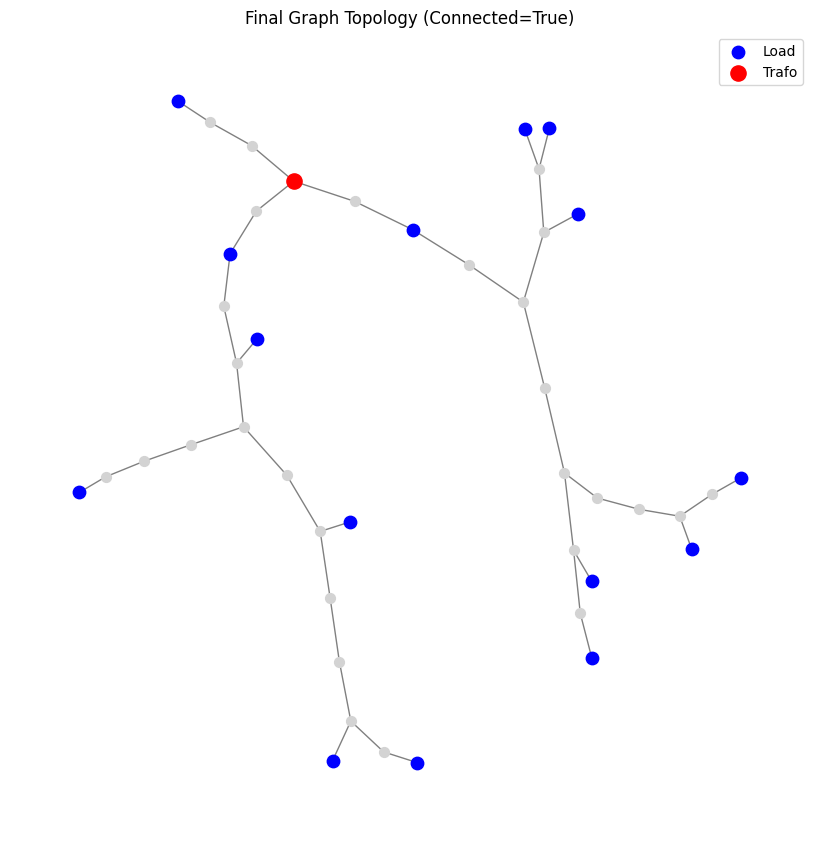

In [4]:
# 1. 保存
processed_data = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "X": X_norm,       # Global Context
    "Y_v": Y_v_norm,   # Node Voltages (Target)
    "Y_p": Y_p_norm,   # Node Injections (Input Feature)
    "train_idx": train_idx,
    "val_idx": val_idx,
    "test_idx": test_idx,
    "scalers": scalers,
    "n_nodes": n_nodes
}

torch.save(processed_data, SAVE_PATH)
print(f"✅ Saved processed dataset to {SAVE_PATH}")

# 2. 最终验证：画图检查连通性
print("\n🔍 Verifying Graph Connectivity...")
G = nx.Graph()
G.add_nodes_from(range(n_nodes))
G.add_edges_from(edge_index.t().numpy())

is_connected = nx.is_connected(G)
components = list(nx.connected_components(G))

print(f"   Is Connected? {is_connected}")
if is_connected:
    print("🎉 SUCCESS: Graph is fully connected! Ready for GNN.")
else:
    print(f"❌ ERROR: Graph is disconnected! Components: {len(components)}")

# 简单绘图
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw(G, pos, node_size=50, node_color='lightgray', edge_color='gray')
nx.draw_networkx_nodes(G, pos, nodelist=load_map, node_color='blue', node_size=80, label='Load')
nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=120, label='Trafo')
plt.title(f"Final Graph Topology (Connected={is_connected})")
plt.legend()
plt.show()

📂 Loading data for visualization...
🔍 Detecting Node Roles based on Power Profiles...
   Trafo Nodes: 1
   PV Nodes (Gen): 10 (Marked Orange)
   Load Nodes (Con): 5 (Marked Blue)
   Junctions: 28 (Marked Gray)


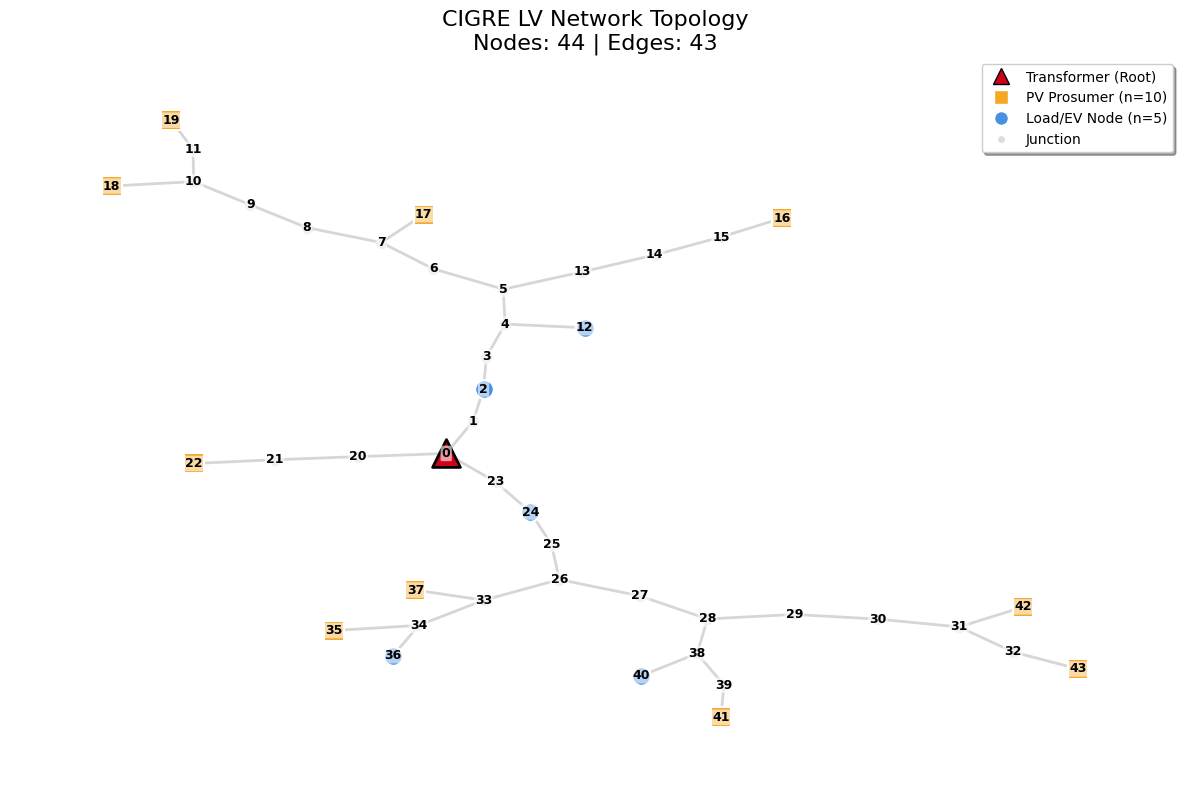

✅ Visualization Complete.


In [11]:
import networkx as nx
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 路径配置
SAVE_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"

# --- 1. 加载数据 (关键修正: weights_only=False) ---
print("📂 Loading data for visualization...")
try:
    # PyTorch 2.6+ 必须加上 weights_only=False 才能加载 sklearn 对象
    data = torch.load(SAVE_PATH, weights_only=False)
except TypeError:
    # 旧版本 PyTorch 不需要此参数
    data = torch.load(SAVE_PATH)

edge_index = data["edge_index"]
n_nodes = data["n_nodes"]
Y_p_tensor = data["Y_p"] # [Samples, Nodes] 归一化后的功率数据

# --- 2. 构建图结构 ---
G = nx.Graph()
G.add_nodes_from(range(n_nodes))
G.add_edges_from(edge_index.t().numpy())

# --- 3. 节点角色识别 (基于数据的物理推断) ---
print("🔍 Detecting Node Roles based on Power Profiles...")

# A. 变压器 (Trafo) - 默认 0 号节点
trafo_node = [0] 

# B. 识别 PV 和 纯负荷
# 逻辑：检查每个节点的功率分布。
# 如果某节点的功率出现显著负值 (归一化后 < -0.5)，说明它向电网倒送了电 -> PV 用户
# 如果某节点的功率始终较大且为正 -> 重负荷/EV
# 如果某节点的功率几乎为 0 -> 中间连接点 (Junction)

pv_nodes = []
load_nodes = []
junction_nodes = []

# 计算每个节点的特征统计量
p_min = Y_p_tensor.min(dim=0).values.numpy() # 最小值
p_std = Y_p_tensor.std(dim=0).numpy()        # 标准差 (波动率)

for i in range(n_nodes):
    if i in trafo_node: continue
    
    # 阈值判断 (基于归一化数据)
    # 归一化后，均值约 0。PV 发电时 P < 0。
    if p_min[i] < -1.0: 
        # 经常反送电 -> PV 用户
        pv_nodes.append(i)
    elif p_std[i] > 0.1:
        # 波动较大但没有显著反送 -> 纯负荷 / EV
        load_nodes.append(i)
    else:
        # 波动极小 -> 连接点
        junction_nodes.append(i)

print(f"   Trafo Nodes: {len(trafo_node)}")
print(f"   PV Nodes (Gen): {len(pv_nodes)} (Marked Orange)")
print(f"   Load Nodes (Con): {len(load_nodes)} (Marked Blue)")
print(f"   Junctions: {len(junction_nodes)} (Marked Gray)")

# --- 4. 高级绘图 (Visualization) ---
plt.figure(figsize=(12, 8))

# 使用 Kamada-Kawai 布局 (适合展示电网的物理结构)
pos = nx.kamada_kawai_layout(G) 

# A. 绘制边 (灰色连线)
nx.draw_networkx_edges(G, pos, edge_color='#CCCCCC', width=2.0, alpha=0.8)

# B. 分层绘制节点
# 1. Junctions (中间点) - 小灰点
nx.draw_networkx_nodes(G, pos, nodelist=junction_nodes, node_size=50, node_color='#DDDDDD', label='Junction')

# 2. Pure Loads (普通用户/EV) - 蓝色圆点
nx.draw_networkx_nodes(G, pos, nodelist=load_nodes, node_size=180, node_color='#4A90E2', node_shape='o', edgecolors='white', linewidths=1.5, label='Load/EV')

# 3. PV Nodes (产消者) - 橙色方块
nx.draw_networkx_nodes(G, pos, nodelist=pv_nodes, node_size=220, node_color='#F5A623', node_shape='s', edgecolors='white', linewidths=1.5, label='PV Prosumer')

# 4. Trafo (变压器) - 红色大三角
nx.draw_networkx_nodes(G, pos, nodelist=trafo_node, node_size=400, node_color='#D0021B', node_shape='^', edgecolors='black', linewidths=2.0, label='Trafo (Slack)')

# C. 绘制节点数字编号 (带背景框)
labels = {i: str(i) for i in range(n_nodes)}
text_items = nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color='black', font_weight='bold')
# 给文字加白色半透明背景，防止被线遮挡
for t in text_items.values():
    t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.1'))

# D. 装饰与图例
plt.title(f"CIGRE LV Network Topology\nNodes: {n_nodes} | Edges: {edge_index.shape[1]//2}", fontsize=16)
plt.axis('off')

# 自定义精美图例
legend_handles = [
    mlines.Line2D([], [], color='white', marker='^', markerfacecolor='#D0021B', markeredgecolor='black', markersize=12, label='Transformer (Root)'),
    mlines.Line2D([], [], color='white', marker='s', markerfacecolor='#F5A623', markeredgecolor='white', markersize=10, label=f'PV Prosumer (n={len(pv_nodes)})'),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='#4A90E2', markeredgecolor='white', markersize=10, label=f'Load/EV Node (n={len(load_nodes)})'),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor='#DDDDDD', markersize=6, label='Junction'),
]
plt.legend(handles=legend_handles, loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Visualization Complete.")

In [10]:
import torch
import networkx as nx
import numpy as np
import sys
import os

def verify_dataset(file_path):
    print(f"🕵️ Starting Deep Inspection for: {os.path.basename(file_path)}")
    print("="*60)
    
    # --- 1. Load Check (兼容 PyTorch 2.6+ 安全机制) ---
    if not os.path.exists(file_path):
        print(f"❌ [File] Not found: {file_path}")
        return False
        
    try:
        # 尝试使用 weights_only=False 加载 (支持 numpy/sklearn 对象)
        data = torch.load(file_path, weights_only=False)
        print(f"✅ [Load] File loaded successfully.")
    except TypeError:
        # 旧版本 PyTorch 兼容
        data = torch.load(file_path)
        print(f"✅ [Load] File loaded (Legacy mode).")
    except Exception as e:
        print(f"❌ [Load] Failed: {e}")
        return False

    # --- 2. Key Existence Check ---
    required_keys = ['edge_index', 'edge_attr', 'X', 'Y_v', 'Y_p', 
                     'train_idx', 'val_idx', 'test_idx', 'scalers', 'n_nodes']
    missing = [k for k in required_keys if k not in data]
    if missing:
        print(f"❌ [Structure] Missing keys: {missing}")
        return False
    print(f"✅ [Structure] All keys present.")

    # --- 3. Dimension Check (根据实际逻辑修正) ---
    n_samples = data['X'].shape[0]
    n_nodes = data['n_nodes']  # 应该是 44
    
    # 期望的形状
    expected_shapes = {
        "X (Global Context)": (n_samples, 3),      # [N, 3] -> P_tot, Q_tot, Time
        "Y_v (Target Voltage)": (n_samples, n_nodes), # [N, 44]
        "Y_p (Input Power)": (n_samples, n_nodes)     # [N, 44]
    }
    
    dim_error = False
    for name, expected in expected_shapes.items():
        key = name.split()[0] # 获取键名 (X, Y_v, Y_p)
        actual = data[key].shape
        if actual != expected:
            print(f"❌ [Dimensions] {name} mismatch! Got {actual}, Expected {expected}")
            dim_error = True
        else:
            print(f"✅ [Dimensions] {name}: {actual} OK")
            
    if dim_error: return False

    # --- 4. Topology Connectivity Check (最关键!) ---
    edge_index = data['edge_index']
    num_edges = edge_index.shape[1]
    
    # 转 NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    edges = edge_index.t().numpy()
    G.add_edges_from(edges)
    
    is_connected = nx.is_connected(G)
    components = list(nx.connected_components(G))
    
    print(f"ℹ️ [Topology] Nodes: {G.number_of_nodes()}, Physical Edges: {num_edges//2}")
    
    if is_connected:
        print(f"✅ [Topology] Graph is FULLY CONNECTED. Transformer reaches all nodes.")
    else:
        print(f"❌ [Topology] Graph is DISCONNECTED! Found {len(components)} components.")
        print(f"   - Largest component size: {len(max(components, key=len))}")
        print(f"   - Isolated nodes: {[list(c) for c in components if len(c) < 5]}")
        return False

    # --- 5. Value Integrity Check ---
    # 检查是否有 NaN/Inf
    tensors_to_check = ['X', 'Y_v', 'Y_p']
    for t_name in tensors_to_check:
        t = data[t_name]
        if torch.isnan(t).any() or torch.isinf(t).any():
            print(f"❌ [Values] {t_name} contains NaN or Inf!")
            return False
            
    print(f"✅ [Values] No NaNs or Infs found.")

    # --- 6. Scaler Check ---
    scalers = data['scalers']
    if 'x' in scalers and 'y_v' in scalers and 'y_p' in scalers:
        print(f"✅ [Scalers] Scikit-learn scalers preserved.")
    else:
        print(f"❌ [Scalers] Missing scaler objects.")
        return False

    print("="*60)
    print("🎉 FINAL VERDICT: DATASET IS PERFECT.")
    return True

# --- 执行 ---
# 请确保路径与你实际保存的一致
check_path = "../data/processed/cigre_lv_graph_dataset_v1.pt"
verify_dataset(check_path)

🕵️ Starting Deep Inspection for: cigre_lv_graph_dataset_v1.pt
✅ [Load] File loaded successfully.
✅ [Structure] All keys present.
✅ [Dimensions] X (Global Context): torch.Size([50016, 3]) OK
✅ [Dimensions] Y_v (Target Voltage): torch.Size([50016, 44]) OK
✅ [Dimensions] Y_p (Input Power): torch.Size([50016, 44]) OK
ℹ️ [Topology] Nodes: 44, Physical Edges: 43
✅ [Topology] Graph is FULLY CONNECTED. Transformer reaches all nodes.
✅ [Values] No NaNs or Infs found.
✅ [Scalers] Scikit-learn scalers preserved.
🎉 FINAL VERDICT: DATASET IS PERFECT.


True